# **Croatia data**

Running this notebook does not require a GPU. You can use a frontal node. However, certain parts such as detecting bounding boxes or removing the background from images require GPUs which are launched in external jobs.

In [1]:
# Allow reloading of libraries without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from PIL import Image
from pathlib import Path

from lynx_id.utils.preprocess.utils import check_filepath, flatten_bbox, get_no_and_multiple_bbox, separate_single_multiple_df, plot_images_conf, absolute_coordinates_bbox
from lynx_id.utils.megadetector.utils import crop_bbox

from idr_pytools import display_slurm_queue, gpu_jobs_submitter, search_log
from megadetector.detection.run_detector_batch import load_and_run_detector_batch, write_results_to_file
from megadetector.utils import path_utils

os.environ['WANDB_DISABLED'] = 'true'  # for megadetector

In [3]:
# GPU parameters for jobs to be launched (MegaDetector + SAM)
MODULE = 'pytorch-gpu/py3/2.2.0'
account = 'ads@v100'

In [4]:
DATASET = Path("/gpfsscratch/rech/ads/commun/datasets/extracted/")
COUNTRY = "croatia"
CROATIAN_DATASET_PATH = Path("/gpfsscratch/rech/ads/commun/datasets/extracted/croatia")
NO_BACKGROUND = Path("/gpfsscratch/rech/ads/commun/datasets/extracted/no_background_new")

---

## **Get images (filepath + lynx_id)**

In [30]:
df_country = pd.read_excel(CROATIAN_DATASET_PATH / "list_of_lynx_photos1.xlsx")
df_country

,datum_vrijeme,pouzdanost,broj_zivotinja,broj_mladih,img,oznaka,ime,naziv,spol,lokacija,slikana_strana_zivotinje,lat,lon
0,2016-05-19 01:15:00,1,1,0,lynx/photos/RIS.JPG,Varošina 2016,Image,Geonatura d.o.o.,Unknown,POINT (15.439715 44.630702),right,15.439715,44.630702
1,2016-10-22 03:18:00,1,1,0,lynx/photos/PICT0290.JPG,Goran ZIP L09,Image,JU Priroda,M,POINT (14.9107031584 45.2327798187),left,14.910703,45.232780
2,2016-10-23 11:35:00,1,1,0,lynx/photos/PICT0310_GfUlKy6.JPG,Goran ZIP L09,Image,JU Priroda,M,POINT (14.9107031584 45.2327798187),right,14.910703,45.232780
3,2013-12-10 10:21:00,1,1,0,lynx/photos/PICT0236.JPG,Pakleni,Image,NP Paklenica,Unknown,POINT (15.4829004594 44.3279410748),none,15.482900,44.327941
4,2014-09-13 17:49:00,1,1,0,lynx/photos/PICT0001_8J6PCAA.JPG,Nik,Image,NP Paklenica,Unknown,POINT (15.4792073827 44.3398982543),left,15.479207,44.339898
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007,2023-05-13 18:06:00,1,1,0,lynx/photos/B1000363.JPG,Slavko L35,Image,Veterinarski fakultet,M,POINT (14.949509 45.144032),left,14.949509,45.144032
2008,2022-04-05 05:31:00,1,1,0,lynx/photos/PICT0082_8hHOzSQ.JPG,Vilim,Image,PP Velebit,M,POINT (15.043362 44.881497),left,15.043362,44.881497
2009,2023-10-20 06:40:00,1,2,1,lynx/photos/IMG-20231112-WA0007.jpg,Crno jezero2 mladunac 2023,Image,Veterinarski fakultet,Unknown,POINT (15.24886 44.828308),left,15.248860,44.828308
2010,2023-10-20 06:40:00,1,2,1,lynx/photos/IMG-20231112-WA0007.jpg,Crno jezero 2,Image,Veterinarski fakultet,Z,POINT (15.24886 44.828308),left,15.248860,44.828308


### **Column renaming**

In [31]:
names = {
    "datum_vrijeme": "date",
    "img": "filepath",
    "oznaka": "lynx_id",
    "spol": "sex",
    "lat": "latitude",
    "lon": "longitude",
    "slikana_strana_zivotinje": "side",
    "broj_zivotinja": "number_animals",
    "broj_mladih": "number_children",
    "naziv": "source", # doubt
}

df_country.rename(columns=names, inplace=True)
df_country

,date,pouzdanost,number_animals,number_children,filepath,lynx_id,ime,source,sex,lokacija,side,latitude,longitude
0,2016-05-19 01:15:00,1,1,0,lynx/photos/RIS.JPG,Varošina 2016,Image,Geonatura d.o.o.,Unknown,POINT (15.439715 44.630702),right,15.439715,44.630702
1,2016-10-22 03:18:00,1,1,0,lynx/photos/PICT0290.JPG,Goran ZIP L09,Image,JU Priroda,M,POINT (14.9107031584 45.2327798187),left,14.910703,45.232780
2,2016-10-23 11:35:00,1,1,0,lynx/photos/PICT0310_GfUlKy6.JPG,Goran ZIP L09,Image,JU Priroda,M,POINT (14.9107031584 45.2327798187),right,14.910703,45.232780
3,2013-12-10 10:21:00,1,1,0,lynx/photos/PICT0236.JPG,Pakleni,Image,NP Paklenica,Unknown,POINT (15.4829004594 44.3279410748),none,15.482900,44.327941
4,2014-09-13 17:49:00,1,1,0,lynx/photos/PICT0001_8J6PCAA.JPG,Nik,Image,NP Paklenica,Unknown,POINT (15.4792073827 44.3398982543),left,15.479207,44.339898
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007,2023-05-13 18:06:00,1,1,0,lynx/photos/B1000363.JPG,Slavko L35,Image,Veterinarski fakultet,M,POINT (14.949509 45.144032),left,14.949509,45.144032
2008,2022-04-05 05:31:00,1,1,0,lynx/photos/PICT0082_8hHOzSQ.JPG,Vilim,Image,PP Velebit,M,POINT (15.043362 44.881497),left,15.043362,44.881497
2009,2023-10-20 06:40:00,1,2,1,lynx/photos/IMG-20231112-WA0007.jpg,Crno jezero2 mladunac 2023,Image,Veterinarski fakultet,Unknown,POINT (15.24886 44.828308),left,15.248860,44.828308
2010,2023-10-20 06:40:00,1,2,1,lynx/photos/IMG-20231112-WA0007.jpg,Crno jezero 2,Image,Veterinarski fakultet,Z,POINT (15.24886 44.828308),left,15.248860,44.828308


### **Drop useless columns**
- lokacija=localisation : useless because this information is found in latitude and longitude
- pouzdanost=reliability : useless because always the same value (1)
- ime=image : useless because always the same value (Image)

In [32]:
df_country.drop(columns=["lokacija", "pouzdanost", "ime"], inplace=True)
df_country

,date,number_animals,number_children,filepath,lynx_id,source,sex,side,latitude,longitude
0,2016-05-19 01:15:00,1,0,lynx/photos/RIS.JPG,Varošina 2016,Geonatura d.o.o.,Unknown,right,15.439715,44.630702
1,2016-10-22 03:18:00,1,0,lynx/photos/PICT0290.JPG,Goran ZIP L09,JU Priroda,M,left,14.910703,45.232780
2,2016-10-23 11:35:00,1,0,lynx/photos/PICT0310_GfUlKy6.JPG,Goran ZIP L09,JU Priroda,M,right,14.910703,45.232780
3,2013-12-10 10:21:00,1,0,lynx/photos/PICT0236.JPG,Pakleni,NP Paklenica,Unknown,none,15.482900,44.327941
4,2014-09-13 17:49:00,1,0,lynx/photos/PICT0001_8J6PCAA.JPG,Nik,NP Paklenica,Unknown,left,15.479207,44.339898
...,...,...,...,...,...,...,...,...,...,...
2007,2023-05-13 18:06:00,1,0,lynx/photos/B1000363.JPG,Slavko L35,Veterinarski fakultet,M,left,14.949509,45.144032
2008,2022-04-05 05:31:00,1,0,lynx/photos/PICT0082_8hHOzSQ.JPG,Vilim,PP Velebit,M,left,15.043362,44.881497
2009,2023-10-20 06:40:00,2,1,lynx/photos/IMG-20231112-WA0007.jpg,Crno jezero2 mladunac 2023,Veterinarski fakultet,Unknown,left,15.248860,44.828308
2010,2023-10-20 06:40:00,2,1,lynx/photos/IMG-20231112-WA0007.jpg,Crno jezero 2,Veterinarski fakultet,Z,left,15.248860,44.828308


### **Duplicates**

There are no duplicate lines.

In [33]:
df_country.duplicated().value_counts()

False    2012
Name: count, dtype: int64

However, some filepaths repeat themselves. **Some images may have several individuals on them. The associated lynx_id are therefore different.**

In [34]:
filepath_value_counts = df_country["filepath"].value_counts()
filepath_value_counts[filepath_value_counts != 1]

filepath
lynx/photos/1_5.JPG                               4
lynx/photos/1_27.JPG                              4
lynx/photos/04.12.20_mlad_2_L.png                 3
lynx/photos/04.12.20_mladunac_2_D.png             3
lynx/photos/mlado_1_desno_TONLL9J.png             3
                                                 ..
lynx/photos/19.01.21._golo_trlo_mladunac_1.png    2
lynx/photos/IMAG0019_nFKMlXN.JPG                  2
lynx/photos/PICT0004.JPG                          2
lynx/photos/25_12_2019_both_interaction_2.JPG     2
lynx/photos/PICT0006.JPG                          2
Name: count, Length: 110, dtype: int64

In [35]:
df_country[df_country["filepath"] == "lynx/photos/1_5.JPG"]

,date,number_animals,number_children,filepath,lynx_id,source,sex,side,latitude,longitude
1715,2023-02-04 18:15:00,4,3,lynx/photos/1_5.JPG,Suzi mladunac3 2022,Rewilding Velebit,Unknown,right,14.958253,44.677339
1716,2023-02-04 18:15:00,4,3,lynx/photos/1_5.JPG,Suzi mladunac2 2022,Rewilding Velebit,Unknown,right,14.958253,44.677339
1717,2023-02-04 18:15:00,4,3,lynx/photos/1_5.JPG,Suzi mladunac1 2022,Rewilding Velebit,Unknown,right,14.958253,44.677339
1718,2023-02-04 18:15:00,4,3,lynx/photos/1_5.JPG,Suzi,Rewilding Velebit,Z,right,14.958253,44.677339


**Note**: it seems complicated to use images with several lynxes in a single image. This is because we don't know which lynx the `lynx_id` refers to in the image.

In [36]:
df_country_multiple_animals = df_country[df_country['number_animals'] > 1]
df_country = df_country[df_country['number_animals'] == 1].copy()

In [37]:
print(len(df_country_multiple_animals))
print(len(df_country))

305
1707


### **Fix filepath**

Checks whether all filepaths currently contain the same prefix

In [38]:
df_country["filepath"].str.startswith("lynx/photos/").all()

True

In [39]:
df_country["filepath"] = df_country["filepath"].str.replace("lynx/photos/", "/gpfsscratch/rech/ads/commun/datasets/extracted/croatia/lynx_pic/")
df_country

,date,number_animals,number_children,filepath,lynx_id,source,sex,side,latitude,longitude
0,2016-05-19 01:15:00,1,0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Varošina 2016,Geonatura d.o.o.,Unknown,right,15.439715,44.630702
1,2016-10-22 03:18:00,1,0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Goran ZIP L09,JU Priroda,M,left,14.910703,45.232780
2,2016-10-23 11:35:00,1,0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Goran ZIP L09,JU Priroda,M,right,14.910703,45.232780
3,2013-12-10 10:21:00,1,0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Pakleni,NP Paklenica,Unknown,none,15.482900,44.327941
4,2014-09-13 17:49:00,1,0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Nik,NP Paklenica,Unknown,left,15.479207,44.339898
...,...,...,...,...,...,...,...,...,...,...
2005,2023-04-20 00:02:00,1,0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Slavko L35,Veterinarski fakultet,M,left,14.949509,45.144032
2006,2023-05-11 12:40:00,1,0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Slavko L35,Veterinarski fakultet,M,left,14.949509,45.144032
2007,2023-05-13 18:06:00,1,0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Slavko L35,Veterinarski fakultet,M,left,14.949509,45.144032
2008,2022-04-05 05:31:00,1,0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Vilim,PP Velebit,M,left,15.043362,44.881497


### **Date**

The dates are already in `datetime64[ns]` format. This is the format used for df_france.

In [40]:
df_country.dtypes

date               datetime64[ns]
number_animals              int64
number_children             int64
filepath                   object
lynx_id                    object
source                     object
sex                        object
side                       object
latitude                  float64
longitude                 float64
dtype: object

In [41]:
df_country.nunique()

date               1380
number_animals        1
number_children       2
filepath           1706
lynx_id             183
source               12
sex                   3
side                  5
latitude            332
longitude           331
dtype: int64

### **Sex**

In [42]:
df_country["sex"].value_counts()

sex
M          912
Unknown    453
Z          342
Name: count, dtype: int64

In [43]:
df_country['sex'] = df_country['sex'].replace({'M': 'Male', 'Z': 'Female'})
df_country.shape

(1707, 10)

### **Deleting broken images**

In [44]:
all_files_exist = all(df_country['filepath'].apply(os.path.exists))
all_files_exist

True

## **Bounding box detection**

In [45]:
country_output_megadetector = DATASET / COUNTRY / f"bbox_{COUNTRY}.json"  # WARNING: change filename if needed
country_output_megadetector

PosixPath('/gpfsscratch/rech/ads/commun/datasets/extracted/croatia/bbox_croatia.json')

In [46]:
image_filenames = df_country['filepath'].tolist()
len(image_filenames)

1707

In [47]:
# Bounding box calculation is externalised to another job
image_filenames_path = f"image_filenames_{COUNTRY}.txt"
with open(image_filenames_path, 'w') as f:
    json.dump(image_filenames, f)

n_gpu = 1
command = f'run_megadetector.py --image_filenames_path {image_filenames_path} --output_megadetector {country_output_megadetector}'

jobid = gpu_jobs_submitter(command, n_gpu, MODULE, name=f"megadetector_{COUNTRY}",
                   account=account, time_max='04:00:00', constraint='v100-32g', qos='qos_gpu-t3')
print(f'jobid = {jobid}')

batch job 0: 1 GPUs distributed on 1 nodes with 1 tasks / 1 gpus per node and 10 cpus per task
Submitted batch job 326007
jobid = ['326007']


In [48]:
display_slurm_queue(name=f"megadetector_{COUNTRY}", timestep=60)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            326007   gpu_p13 megadete  uxp55sd  R       4:44      1 r6i6n8

 Done!


In [49]:
with open(country_output_megadetector, 'r') as f:
    bbox_country = json.load(f)

Some images may not have bounding boxes found.

In [50]:
no_bbox_country, multiple_bbox_country = get_no_and_multiple_bbox(bbox_country)

19 images have no bounding boxes detected.
25 images have several bounding boxes detected.
Total: 1707 images.


Absolute coordinates of the bounding box (x, y, width and height) based on the image dimensions

In [51]:
df_bbox_country = flatten_bbox(bbox_country, add_image_without_bbox=False, verbose=False)
df_bbox_country = absolute_coordinates_bbox(df_bbox_country)

df_bbox_country

,file,im_width,im_height,category,conf,x,y,width,height
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,2592,2000,1,0.932,1068.94080,895.8000,440.8992,272.0000
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,2816,2112,1,0.915,707.94240,645.8496,848.7424,551.8656
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,2816,2112,1,0.944,197.99296,768.9792,1275.9296,761.7984
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,2816,2112,1,0.822,1168.92160,702.8736,626.8416,245.8368
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,2816,2112,1,0.936,1396.73600,874.7904,571.9296,660.8448
...,...,...,...,...,...,...,...,...,...
1712,/gpfsscratch/rech/ads/commun/datasets/extracte...,1600,1200,1,0.951,736.00000,483.9600,245.9200,255.9600
1713,/gpfsscratch/rech/ads/commun/datasets/extracte...,1600,1200,1,0.840,873.92000,438.0000,112.0000,327.0000
1714,/gpfsscratch/rech/ads/commun/datasets/extracte...,1600,1200,1,0.897,752.96000,486.0000,232.9600,248.8800
1715,/gpfsscratch/rech/ads/commun/datasets/extracte...,4000,3000,1,0.952,256.96000,1865.7000,734.8000,773.7000


In [52]:
df_bbox_country.nunique()['file']

1687

### **10 images cropped with the least confidence are displayed**

Only images with a single bounding box are displayed.

In [53]:
df_bbox_country_single_detection, df_bbox_country_multiple_detections = separate_single_multiple_df(df_bbox_country)

print(len(df_bbox_country_single_detection))
print(len(df_bbox_country_multiple_detections))

1663
54


In [54]:
%matplotlib inline

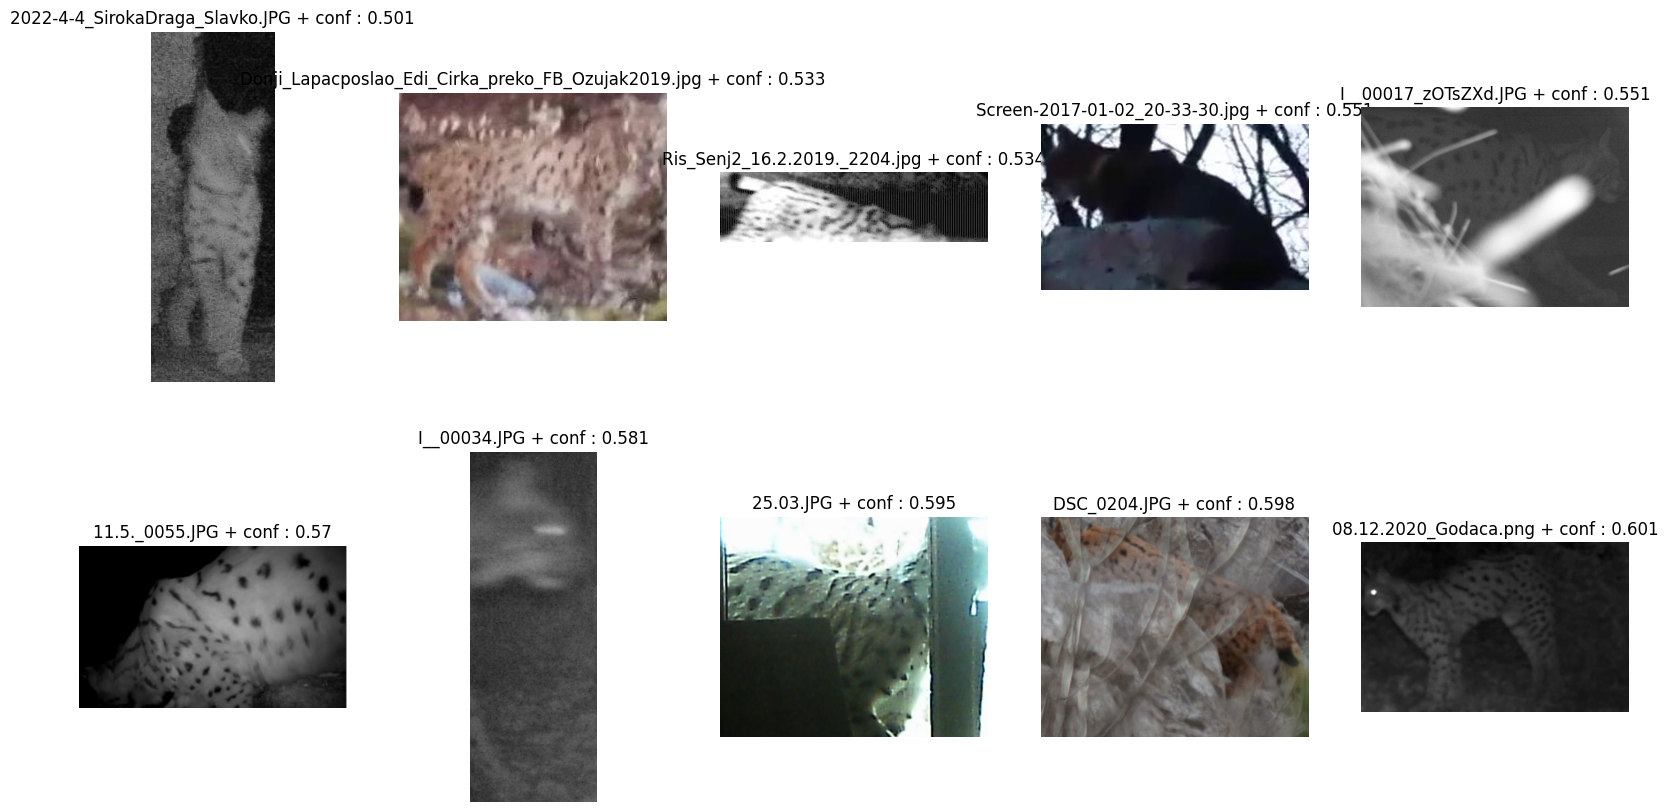

In [55]:
plot_images_conf(df_bbox_country_single_detection, by="smallest")

### **10 images cropped with the largest confidence are displayed**

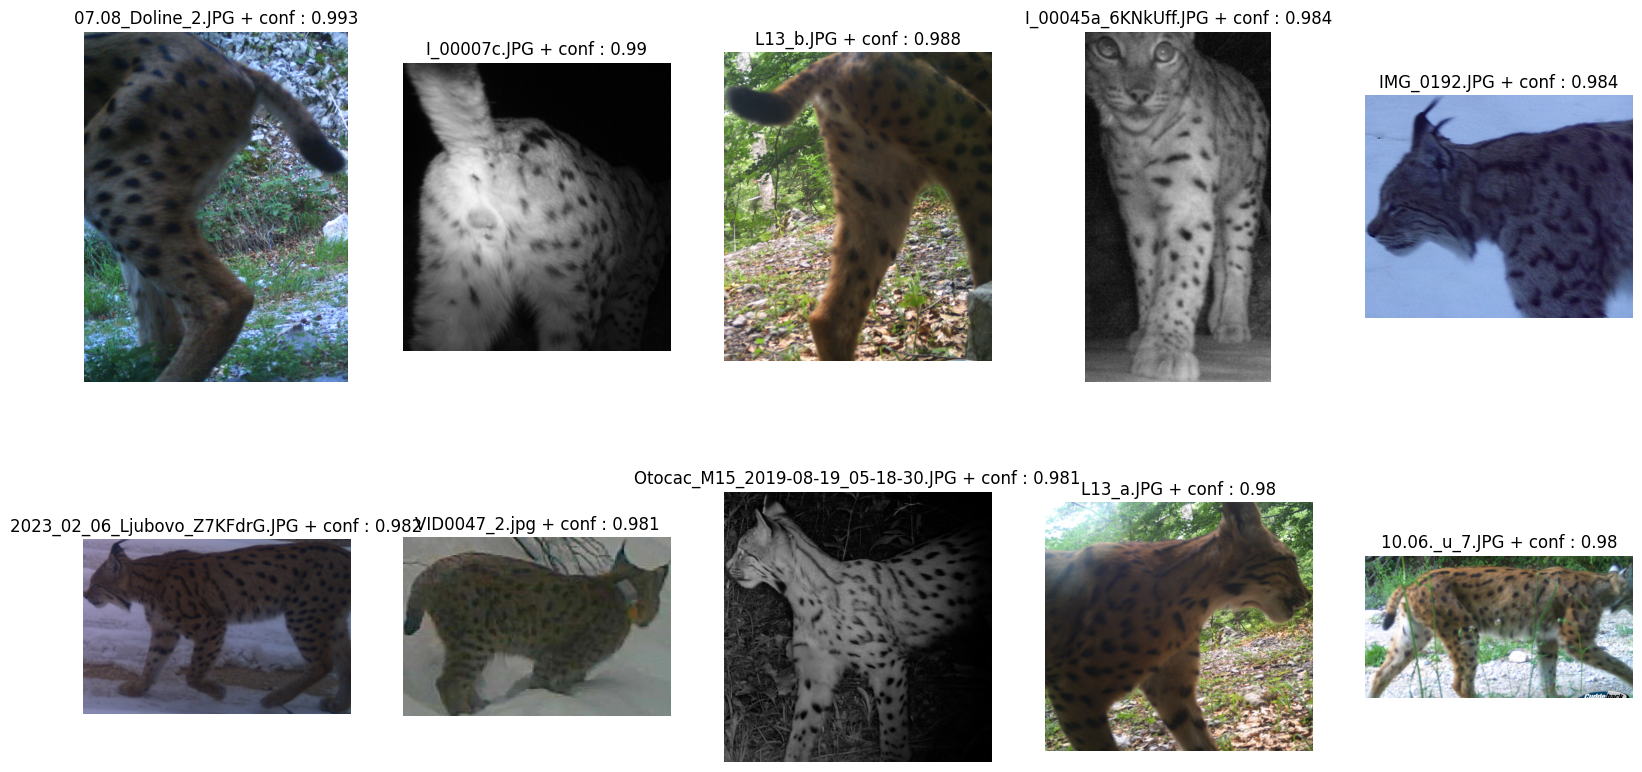

In [56]:
plot_images_conf(df_bbox_country_single_detection, by="largest")

In [57]:
df_country_with_bbox = pd.merge(df_country, df_bbox_country_single_detection[['file', 'conf', 'x', 'y', 'width', 'height']], how='inner', left_on='filepath', right_on='file')
df_country_with_bbox = df_country_with_bbox.drop('file', axis=1)

df_country_with_bbox

,date,number_animals,number_children,filepath,lynx_id,source,sex,side,latitude,longitude,conf,x,y,width,height
0,2016-05-19 01:15:00,1,0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Varošina 2016,Geonatura d.o.o.,Unknown,right,15.439715,44.630702,0.932,1068.94080,895.8000,440.8992,272.0000
1,2016-10-22 03:18:00,1,0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Goran ZIP L09,JU Priroda,Male,left,14.910703,45.232780,0.915,707.94240,645.8496,848.7424,551.8656
2,2016-10-23 11:35:00,1,0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Goran ZIP L09,JU Priroda,Male,right,14.910703,45.232780,0.944,197.99296,768.9792,1275.9296,761.7984
3,2013-12-10 10:21:00,1,0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Pakleni,NP Paklenica,Unknown,none,15.482900,44.327941,0.822,1168.92160,702.8736,626.8416,245.8368
4,2014-09-13 17:49:00,1,0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Nik,NP Paklenica,Unknown,left,15.479207,44.339898,0.936,1396.73600,874.7904,571.9296,660.8448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658,2023-04-20 00:02:00,1,0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Slavko L35,Veterinarski fakultet,Male,left,14.949509,45.144032,0.951,736.00000,483.9600,245.9200,255.9600
1659,2023-05-11 12:40:00,1,0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Slavko L35,Veterinarski fakultet,Male,left,14.949509,45.144032,0.840,873.92000,438.0000,112.0000,327.0000
1660,2023-05-13 18:06:00,1,0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Slavko L35,Veterinarski fakultet,Male,left,14.949509,45.144032,0.897,752.96000,486.0000,232.9600,248.8800
1661,2022-04-05 05:31:00,1,0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Vilim,PP Velebit,Male,left,15.043362,44.881497,0.952,256.96000,1865.7000,734.8000,773.7000


#### Bounding box confidence distribution

<Axes: xlabel='conf', ylabel='Count'>

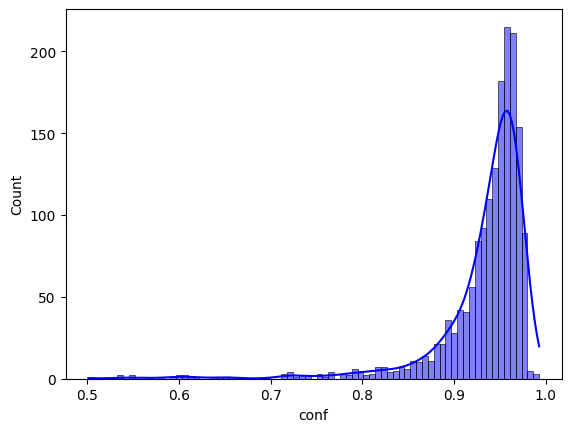

In [58]:
import seaborn as sns

sns.histplot(df_country_with_bbox["conf"], kde=True, color='blue')

## **Compute `image_number` for each individual**

This number is no longer the same as initially following filtering, particularly of images with no bounding box detected, for example.

In [59]:
df_country_with_bbox['image_number'] = df_country_with_bbox.groupby('lynx_id').cumcount() + 1
df_country_with_bbox

,date,number_animals,number_children,filepath,lynx_id,source,sex,side,latitude,longitude,conf,x,y,width,height,image_number
0,2016-05-19 01:15:00,1,0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Varošina 2016,Geonatura d.o.o.,Unknown,right,15.439715,44.630702,0.932,1068.94080,895.8000,440.8992,272.0000,1
1,2016-10-22 03:18:00,1,0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Goran ZIP L09,JU Priroda,Male,left,14.910703,45.232780,0.915,707.94240,645.8496,848.7424,551.8656,1
2,2016-10-23 11:35:00,1,0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Goran ZIP L09,JU Priroda,Male,right,14.910703,45.232780,0.944,197.99296,768.9792,1275.9296,761.7984,2
3,2013-12-10 10:21:00,1,0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Pakleni,NP Paklenica,Unknown,none,15.482900,44.327941,0.822,1168.92160,702.8736,626.8416,245.8368,1
4,2014-09-13 17:49:00,1,0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Nik,NP Paklenica,Unknown,left,15.479207,44.339898,0.936,1396.73600,874.7904,571.9296,660.8448,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658,2023-04-20 00:02:00,1,0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Slavko L35,Veterinarski fakultet,Male,left,14.949509,45.144032,0.951,736.00000,483.9600,245.9200,255.9600,57
1659,2023-05-11 12:40:00,1,0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Slavko L35,Veterinarski fakultet,Male,left,14.949509,45.144032,0.840,873.92000,438.0000,112.0000,327.0000,58
1660,2023-05-13 18:06:00,1,0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Slavko L35,Veterinarski fakultet,Male,left,14.949509,45.144032,0.897,752.96000,486.0000,232.9600,248.8800,59
1661,2022-04-05 05:31:00,1,0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Vilim,PP Velebit,Male,left,15.043362,44.881497,0.952,256.96000,1865.7000,734.8000,773.7000,88


## **Add other information**

In [60]:
needed_columns = ['source', 'pattern', 'date', 'location']
for col in needed_columns:
    if col not in df_country_with_bbox.columns:
        df_country_with_bbox[col] = np.nan

In [61]:
df_country_with_bbox['country'] = COUNTRY

In [62]:
df_country_with_bbox.to_csv(DATASET / COUNTRY / f"lynx_dataset_{COUNTRY}.csv", index=False)

## **Remove backgrounds**

Images without backgrounds are calculated using the `Segment Anything Model`. These are saved here: `/gpfsscratch/rech/ads/commun/datasets/extracted/no_background`.  
The csv file is completed with a `filepath_no_bg` column and saved here: `/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset_full_no_bg.csv`

In [5]:
df_country_with_bbox = pd.read_csv(DATASET / f"{COUNTRY}" / f"lynx_dataset_{COUNTRY}.csv")

### **Add the `filepath_no_bg` column based on existing images**

In [6]:
df_country_with_bbox['filepath_no_bg'] = df_country_with_bbox.apply(lambda row: check_filepath(NO_BACKGROUND, COUNTRY, row['filepath'], row['lynx_id'], row['image_number']), axis=1)

In [7]:
print(f"Number of images remaining to be calculated: {df_country_with_bbox['filepath_no_bg'].isna().sum()}")

Number of images remaining to be calculated: 1663


In [8]:
df_country_with_bbox.to_csv(DATASET / COUNTRY / f"lynx_dataset_{COUNTRY}.csv", index=False)

In [9]:
n_gpu = 1
csv_file = f"/gpfsscratch/rech/ads/commun/datasets/extracted/{COUNTRY}/lynx_dataset_{COUNTRY}.csv"
save_img_directory = NO_BACKGROUND
command = f'remove_background.py --csv_file {csv_file} --save_img_directory {save_img_directory} --skip_already_computed'

jobid = gpu_jobs_submitter(command, n_gpu, MODULE, name=f'sam_{COUNTRY}', account=account, time_max='04:00:00')
print(f'jobid = {jobid}')

batch job 0: 1 GPUs distributed on 1 nodes with 1 tasks / 1 gpus per node and 10 cpus per task
Submitted batch job 350849
jobid = ['350849']


In [10]:
display_slurm_queue(name=f'sam_{COUNTRY}', timestep=60)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            350849   gpu_p13 sam_croa  uxp55sd  R      28:40      1 r7i5n8

 Done!


In [5]:
df_full = pd.read_csv(DATASET / f"{COUNTRY}" / f"lynx_dataset_{COUNTRY}.csv")

In [6]:
df_full.groupby('country').nunique()[['filepath', 'filepath_no_bg']]

,filepath,filepath_no_bg
country,,
croatia,1663,1663


In [7]:
all_files_exist = df_full['filepath_no_bg'].apply(lambda x: pd.isna(x) or os.path.exists(x)).all()
assert all_files_exist

## **Fix lynx_id**

In [5]:
df_full = pd.read_csv(DATASET / f"{COUNTRY}" / f"lynx_dataset_{COUNTRY}.csv")

In [6]:
len(sorted(set(df_full.lynx_id.tolist())))

181

In [7]:
df_full['lynx_id'] = df_full['lynx_id'].str.lower()
len(sorted(set(df_full.lynx_id.tolist())))

181

In [8]:
df_full['lynx_id'] = df_full['lynx_id'].str.strip()
len(set(df_full.lynx_id.tolist()))

181

In [9]:
print(sorted(set(df_full.lynx_id.tolist())))

['abel', 'alf', 'alojzije l24', 'amber', 'andreja l17', 'anton', 'arabella', 'benjamin', 'beta', 'bill', 'bjorn', 'brlog', 'buna', 'burni zip l12', 'crno jezero 1', 'crno jezero 2', 'cro279', 'cro327', 'cro372_1', 'cro583', 'cro584', 'damir', 'danielle', 'dante', 'dean', 'delta', 'djuro', 'dol', 'doru l19', 'draž', 'draž 2', 'ed', 'embal', 'emil', 'enver', 'equa', 'fefo', 'fly', 'franjka', 'frida', 'frida mladunac1 2021', 'fulir', 'gaia', 'gavin', 'gavrilo', 'geonatura 1l', 'geonatura 2d', 'geonatura 3d', 'geonatura 3l', 'geonatura 4d', 'geonatura 4l', 'geonatura 5l', 'geonatura 6l', 'geonatura 7l', 'godaca', 'godaca 2', 'golo trlo 5', 'golo trlo 6', 'golo trlo 7', 'goran zip l09', 'goru', 'grey', 'hook', 'ibsen', 'ilija', 'irena', 'iris', 'jasmina', 'jela lcro21', 'jere', 'josip l29', 'jure', 'kain', 'kali', 'kan', 'kapela', 'kapela 2', 'kazo l23', 'kiko', 'kira', 'koda', 'l10 velebit', 'l11 velebit', 'l13 velebit', 'l15 velebit', 'l19 velebit', 'l3 velebit', 'l4 velebit', 'l6 velebit

In [10]:
df_full.to_csv(DATASET / COUNTRY / f"lynx_dataset_{COUNTRY}.csv", index=False)